In [1]:
%load_ext autoreload
import sys
import os
import numpy as np
import sets
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tinydb
from tinydb import Query


SPARTAN_SOURCE_DIR = os.getenv('SPARTAN_SOURCE_DIR')
sys.path.append(os.path.join(SPARTAN_SOURCE_DIR, 'src/ContactParticleFilter/python'))

import lcm
import experimentanalyzer
import utils as cpfUtils
import spartan.utils.utils as spartanUtils

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: the sets module is deprecated
  """


In [8]:
# logFolderName="20180105-165005_simulation"


configFilename = os.path.join(cpfUtils.getCPFSourceDir(), 'config', 'experiments', 'cpf_experiment_config.yaml')
config = spartanUtils.getDictFromYamlFilename(configFilename)

# pose_names = config["poses"]
pose_names = ['q_nom', 'q_nom_down', 'forward', 'twist']
# force_names = config["force_names"]
force_names = ['iiwa_link_6_3', 'iiwa_link_4_1', 'iiwa_link_5_1',
               'iiwa_link_5_2', 'iiwa_link_6_2', 'iiwa_link_6_1']

#noise_levels = config["noise_levels"]
noise_levels = [0, 0.1, 0.5]

In [9]:
# pose_names = sets.Set()
# force_names = sets.Set()
# for entry in ea.db_analysis.all():
#     pose_names.add(entry['pose_name'])
#     force_names.add(entry['force_name'])

color = ['r','g','b']

FIG_WIDTH = 10

"""
Make heatmap of average position error.
x-axis: contact location
y-axis: robot pose

should be three tables, one for each noise level 
"""
def contact_location_accuracy_heatmap(pose_names, force_names, db_analysis, noise_levels,\
                                      force_name_map=None, **kwargs):
    num_poses = len(pose_names)
    num_forces = len(force_names)
    
    template = np.zeros([num_forces, num_poses])
    
    pos = dict()
    angle = dict()
    force = dict()
    
#     std_dev = dict()
#     std_dev = np.zeros([num_forces, num_poses])
    
    
    
    force_val = np.zeros([num_forces, num_poses])
    force_std_dev = np.zeros([num_forces, num_poses])
    
    
#     width_ratios = [1]*len(noise_levels)
#     width_ratios.append(0.08)
#     pos_fix, pos_ax = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
       
    for k, noise_level in enumerate(noise_levels):
        pos[noise_level] = np.copy(template)
        force[noise_level] = np.copy(template)
        angle[noise_level] = np.copy(template)
        
        pos_vals = pos[noise_level]
        force_vals = force[noise_level]
        angle_vals = angle[noise_level]
        
        for j, pose_name in enumerate(pose_names):
            for i, force_name in enumerate(force_names):
                q = tinydb.Query()
                
                if force_name_map is not None:
                    force_name = force_name_map[force_name]
                    
                res = db_analysis.search( (q.pose_name == pose_name) & (q.force_name == force_name)
                                           & (q.noise_level == noise_level) )
                
                
                pos_list = []
                force_list = []
                angle_list = []
                for trial in res:
                    pos_list.append(100*trial['stats']['position']['mean'])
                    force_list.append(100*trial['stats']['force']['mean'])
                    angle_list.append(trial['stats']['angle']['mean'])
                
                
                
                pos_avg = np.average(np.array(pos_list))
                force_avg = np.average(np.array(force_list))
                angle_avg = np.average(np.array(angle_list))
                
                # scale it to be in cm
                pos_vals[i,j] = pos_avg
#                 std_dev[i,j] = res['stats']['position']['std_dev']

                force_vals[i,j] = force_avg
#                 force_std_dev[i,j] = res['stats']['force']['std_dev']

                angle_vals[i,j] = angle_avg

            
    # now actually make the plots
    figs = dict()
    figs['position'] = makeSubplotAcrossNoiseLevels(pos, noise_levels,\
                                                    cbar_label="force location error (cm)", **kwargs)
    figs['force'] = makeSubplotAcrossNoiseLevels(force, noise_levels,\
                                                 cbar_label="force magnitude error (%)", **kwargs)
    
    figs['angle'] = makeSubplotAcrossNoiseLevels(angle, noise_levels,\
                                                 cbar_label="force direction error (deg)", **kwargs)
    
    return figs

    
"""
Takes data in dict/numpy_array form and makes a nice plot
See https://stackoverflow.com/questions/28356359/one-colorbar-for-seaborn-heatmaps-in-subplot
"""
def makeSubplotAcrossNoiseLevels(data, noise_levels, xlabel="pose", ylabel="contact location", \
                                 addTitles=True, cbar_label="cbar label"):
    width_ratios = [1]*len(noise_levels)
    width_ratios.append(0.08)
    fig, axes = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
    fig.set_figwidth(FIG_WIDTH)
    # now we make the plots
    kwargs = dict()
    kwargs['linewidths'] = 0.5
    kwargs['annot'] = True
    kwargs["fmt"] = "0.1f"
#     kwargs['square'] = True
    axcb = axes[-1]
    axes[0].get_shared_y_axes().join(*axes[0:-1])
    
    # figure out vmin and vmax
    vmin = 0
    vmax = 0
    for key, data_val in data.iteritems():
#         vmin = min(vmin, np.min(data_val))
        vmax = max(vmax, np.max(data_val))
    
    
    kwargs['vmin'] = vmin
    kwargs['vmax'] = vmax
        
    for k, noise_level in enumerate(noise_levels):
        ax = axes[k]
        
        # special logic it's the rightmost one
        if k == (len(noise_levels) - 1):
            g = sns.heatmap(data[noise_level], cmap="YlGnBu", ax=ax, cbar=True,\
                            cbar_ax=axcb, cbar_kws={'label': cbar_label}, **kwargs)
            
        else:
            g = sns.heatmap(data[noise_level], cmap="YlGnBu", cbar=False, ax=ax ,  **kwargs)    
        
        g.set_xlabel(xlabel)
        
        if addTitles:
            title = "Noise " + str(noise_level)
            g.set_title(title)
        
        if k == 0:
            g.set_ylabel(ylabel)
        
        if k > 0:
            g.set_yticks([])
            
    return fig

def savePlotsToFile(plots, prefix):
    spartan_source_dir = os.getenv("SPARTAN_SOURCE_DIR")
    figuresFolder = os.path.join(spartan_source_dir, 'sandbox', 'Figures')
#     os.mkdir(figuresFolder)
    for name, plot in plots.iteritems():
        filename = "kuka_" + prefix + "_" + name + ".png"
        fullFilename = os.path.join(figuresFolder, filename)
        plot.savefig(fullFilename)
        
        
        
# think about making custom plots for comparison to two step estimator
# https://github.com/mwaskom/seaborn/issues/375

def makeTwoStepEstimatorPlots(pose_names, force_names, db_analysis, noise_levels=[0], **kwargs):
    
    num_poses = len(pose_names)
    num_forces = len(force_names)
    
    template = np.zeros([num_forces, num_poses])
    template_bool = np.full([num_forces, num_poses], False, dtype=bool)
    
    pos = dict()
    angle = dict()
    force = dict()
    
    
    tse_data = dict()
    keys = ['position_tse', 'force_tse', 'angle_tse']
    for key in keys:
        tse_data[key] = dict()
        tse_data[key]['mean'] = np.copy(template)
        tse_data[key]['missed_link_surface'] = np.copy(template_bool)
        tse_data[key]['has_at_least_one_valid_estimate'] = np.copy(template_bool)
    
    
    
    force_val = np.zeros([num_forces, num_poses])
    force_std_dev = np.zeros([num_forces, num_poses])
    
    
#     width_ratios = [1]*len(noise_levels)
#     width_ratios.append(0.08)
#     pos_fix, pos_ax = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
       
    for k, noise_level in enumerate(noise_levels):
        pos[noise_level] = np.copy(template)
        force[noise_level] = np.copy(template)
        angle[noise_level] = np.copy(template)
        
        pos_vals = pos[noise_level]
        force_vals = force[noise_level]
        angle_vals = angle[noise_level]
        
        for j, pose_name in enumerate(pose_names):
            for i, force_name in enumerate(force_names):
                q = tinydb.Query()

                    
                res = db_analysis.search( (q.pose_name == pose_name) & (q.force_name == force_name)
                                           & (q.noise_level == noise_level) )
                
                
                pos_list = []
                force_list = []
                angle_list = []
                for trial in res:
                    pos_list.append(100*trial['stats']['position']['mean'])
                    force_list.append(100*trial['stats']['force']['mean'])
                    angle_list.append(trial['stats']['angle']['mean'])
          
                pos_avg = np.average(np.array(pos_list))
                force_avg = np.average(np.array(force_list))
                angle_avg = np.average(np.array(angle_list))
                
                # scale it to be in cm
                pos_vals[i,j] = pos_avg
#                 std_dev[i,j] = res['stats']['position']['std_dev']

                force_vals[i,j] = force_avg
#                 force_std_dev[i,j] = res['stats']['force']['std_dev']

                angle_vals[i,j] = angle_avg
    
    
                for key, val in tse_data.iteritems():
                    for data_name, data_array in val.iteritems():
                        
#                         print "data_name = ", data_name
#                         print type(i)
#                         print "type(data_array) = ", type(data_array)
                        value = res[0]['stats'][key][data_name]
                        
                        if (data_name == "mean") and ( ("position" in key) or ("force" in key) ):
                            value = 100*value
                        
                    
                        data_array[i,j] = value
                        
                        if False:
                            print "pose_name = ", pose_name
                            print "force_name = ", force_name
                            print "key = ", key
                            print "data_name = ", data_name
                            print "value = ", value
                            print "\n"

            
            
    # now actually make the plots
    figs = dict()
#     print "tse_data['position_tse']['mean']\n ", tse_data['position_tse']['mean']
    figs['position'] = makeSingleTwoStepEstimatorPlot(pos_vals, tse_data['position_tse'],\
                                                     cbar_label="force location error (cm)")
    figs['force'] = makeSingleTwoStepEstimatorPlot(force_vals, tse_data['force_tse'],\
                                                  cbar_label="force magnitude error (%)")
    figs['angle'] = makeSingleTwoStepEstimatorPlot(angle_vals, tse_data['angle_tse'],\
                                                  cbar_label="force direction error (deg)")
    return figs
        
    
"""
cpf_data should be numpy array
tse_data should be dict with keys = ['mean', 'missed_link_surface', 'has_atleast_one_valid_estimate']
"""
    
def makeSingleTwoStepEstimatorPlot(cpf_data, tse_data, xlabel="pose", ylabel="contact location", \
                                 addTitles=True, cbar_label="cbar label"):
    num_plots = 2
    width_ratios = [1,1,0.08]
    fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios':width_ratios})
    fig.set_figwidth(FIG_WIDTH)
    
    # now we make the plots
    kwargs = dict()
    kwargs['linewidths'] = 0.5
    kwargs['annot'] = True
    kwargs["fmt"] = "0.1f"
#     kwargs['square'] = True
    axcb = axes[-1]
    axes[0].get_shared_y_axes().join(*axes[0:-1])
    
    # figure out vmin and vmax
    vmin = 0
    vmax = max(np.max(cpf_data), np.max(tse_data['mean']))
    
    kwargs['vmin'] = vmin
    kwargs['vmax'] = vmax
    
    # make cpf plot
    
    g = sns.heatmap(cpf_data, cmap="YlGnBu", cbar=False, ax=axes[0] ,  **kwargs)    
    g.set_xlabel(xlabel)
    g.set_title("Contact Particle Filter")
    g.set_ylabel(ylabel)
    
    
    # make tse plot
    with sns.axes_style("dark"):
        
        # won't show data where mask=True
        
        all_valid_mask = tse_data['missed_link_surface']
        
        some_valid_mask = np.logical_not(tse_data['has_at_least_one_valid_estimate'])
        some_valid_mask = np.logical_or(some_valid_mask, np.logical_not(all_valid_mask))
        
        
#         print "some_but_not_all_valid \n", some_valid_mask
    
        g = sns.heatmap(tse_data['mean'], cmap="YlGnBu", ax=axes[1], cbar=True,\
                                cbar_ax=axcb, cbar_kws={'label': cbar_label},\
                        mask = all_valid_mask, **kwargs)
        
        
        
        g = sns.heatmap(tse_data['mean'], cmap="YlGnBu", ax=axes[1], cbar=True,\
                                        cbar_ax=axcb, cbar_kws={'label': cbar_label},\
                                mask=some_valid_mask, annot_kws={ "color": "red"}, **kwargs)
        g.set_yticks([])
        g.set_title("Two Step Estimator")
        g.set_xlabel(xlabel)
        
        # set color to red as needed
    
    
    
    
    return fig
    

# Simulation Fixed Base Figures
We should make several heatmaps showing the results for simulation from the kuka
- Contact location accuracy for each (force_location, robot_pose) pair
- Contact Force Accuracy for each (force_location, robot_pose) pair

In [10]:
# simulation, fixed base, load the data
# simLogFolderName="20180111-161321_simulation"
# simLogFolderName = "20180116-151327_simulation"
simLogFolderName = "20180116-155538_simulation" # working well
# simLogFolderName = "20180116-175240_simulation"
simLogFolderName = "20180116-182327_simulation" # 3 runs of each
# simLogFolderName = "20180116-195014_simulation"
simLogFolderName = "20180117-175401_simulation"
ea_sim = experimentanalyzer.ExperimentAnalyzer(logFolderName=simLogFolderName, mode="simulation")
ea_sim.run()

# simLogFolderName_2 = "20180116-155538_simulation" # working well
# ea_sim_2 = experimentanalyzer.ExperimentAnalyzer(logFolderName=simLogFolderName_2)
# ea_sim_2.run()

# hardwareLogFolderName ="20180112-161516_hardware"
# ea_hardware = experimentanalyzer.ExperimentAnalyzer(logFolderName=hardwareLogFolderName, mode="hardware")
# ea_hardware.run()

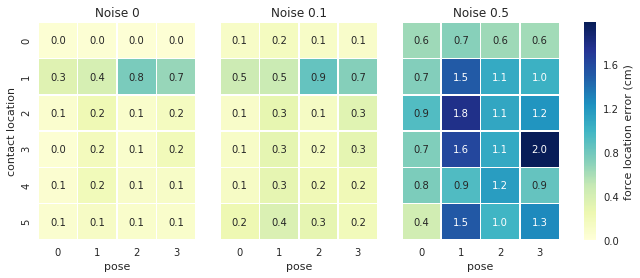

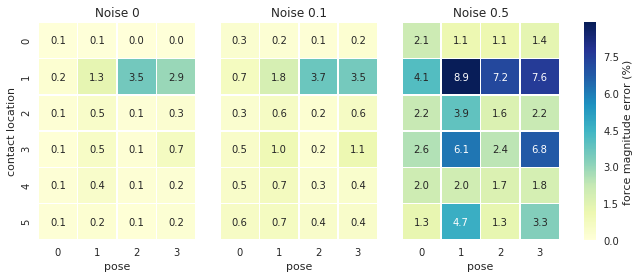

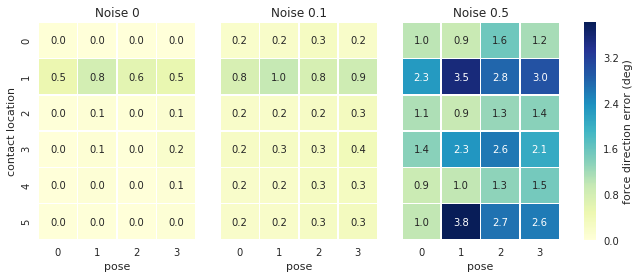

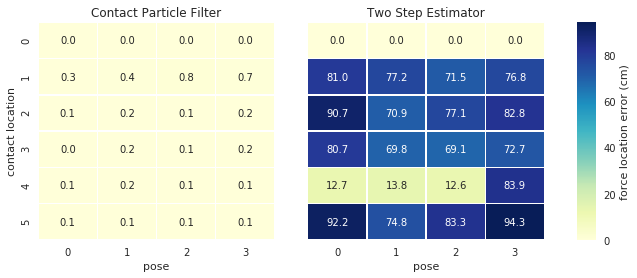

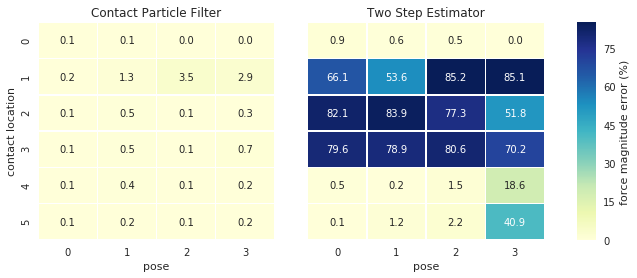

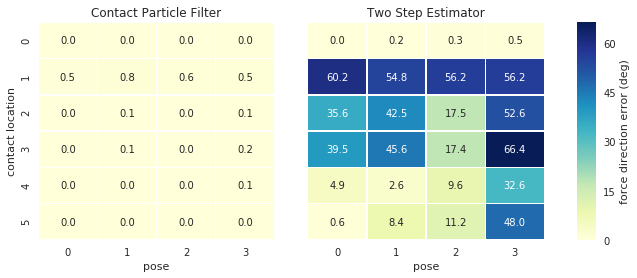

In [11]:
# Filter Performance
plots = contact_location_accuracy_heatmap(pose_names, force_names, ea_sim.db_analysis, noise_levels)
figs = makeTwoStepEstimatorPlots(pose_names, force_names, ea_sim.db_analysis)
savePlotsToFile(figs, "two_step_estimator")
savePlots = True
if savePlots:
    savePlotsToFile(plots, "simulation")
    
# contact_location_accuracy_heatmap(pose_names, force_names, ea_sim_2.db_analysis, noise_levels)

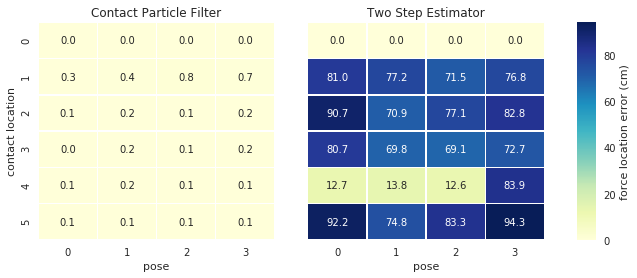

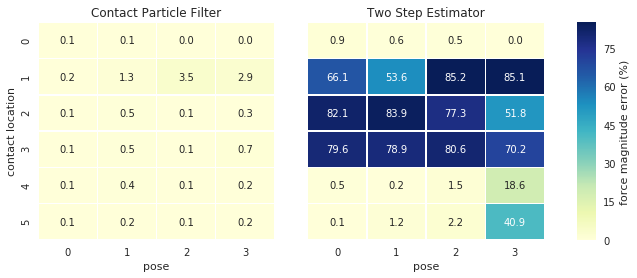

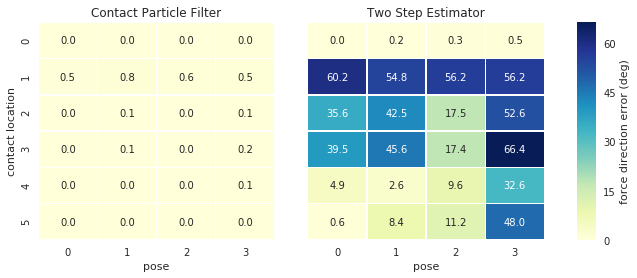

In [12]:
# Comparison to Two Step Estimator
figs = makeTwoStepEstimatorPlots(pose_names, force_names, ea_sim.db_analysis)

if True:
    savePlotsToFile(figs, "two_step_estimator")

In [13]:
q = Query()
res = ea_sim.db_analysis.search((q.pose_name == pose_names[0]) & (q.force_name == force_names[4])\
                                & (q.noise_level == 0))

print type(res[0])
print res[0]['stats']['position_tse']

<class 'tinydb.database.Document'>
{u'missed_link_surface': False, u'has_at_least_one_valid_estimate': True, u'mean': 0.12707248865986914}


# Simulation Floating Base

In [14]:
# load the data for a simulation run with Floating base
floatingBaseLogFolder = "20180129-211203_simulation"
pose_names_fb = ['q_nom']
force_names_fb = [ 'iiwa_link_5_1']
# floating base experiment analyzer
ea_fb = experimentanalyzer.ExperimentAnalyzer(logFolderName=floatingBaseLogFolder, mode="simulation")
ea_fb.run()

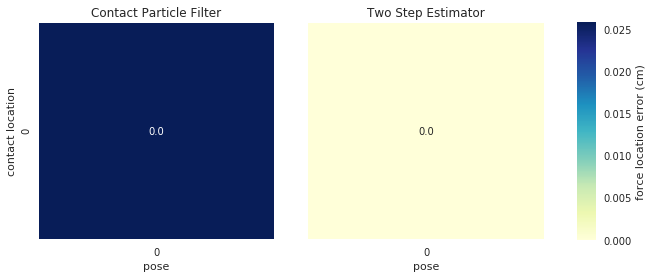

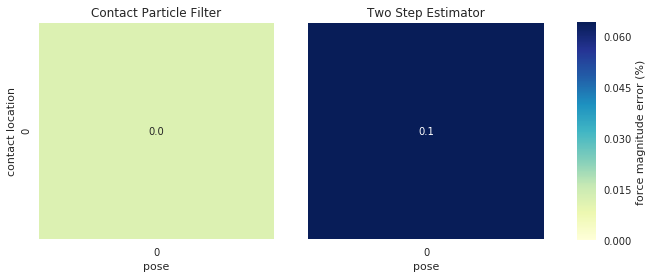

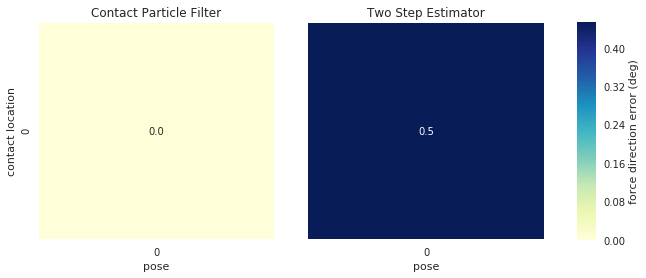

In [15]:
# Comparison to Two Step Estimator
figs = makeTwoStepEstimatorPlots(pose_names_fb, force_names_fb, ea_fb.db_analysis, noise_levels=[0])

if False:
    savePlotsToFile(figs, "two_step_estimator_floating_base")

In [ ]:
q = Query()
pose_name = "q_nom"
force_name = "iiwa_link_5_1"
noise_level = 0
res = ea_fb.db_analysis.search((q.pose_name == pose_name) & (q.force_name == force_name)\
                                & (q.noise_level == noise_level))[0]
print res['lcm_log_file']
print res['stats']['force_tse']

# Hardware

In [ ]:
# load the data for hardware run
# simulation, fixed base, load the data

# this is just copied from the yaml config file for safe keeping
# poses: ['q_nom', 'q_nom_down', 'forward', 'twist']
hardware_force_names = ['iiwa_link_7_1', 'iiwa_link_4_1', 'iiwa_link_5_1', 'iiwa_link_5_2', 'iiwa_link_6_3', 'iiwa_link_6_1'] 


# need to figure out a mapping from force_names in yaml file (and what's used in above sim plots) to what
# we actually did in the hardware experiments


# full hardware run with above poses and force names
hardwareLogFolderName = "20180116-153439_hardware"
hardware_force_name_map = dict()
# maps force_names from sim to this particular hardware run
hardware_force_name_map['iiwa_link_6_3'] = 'iiwa_link_7_1'
hardware_force_name_map['iiwa_link_4_1'] = 'iiwa_link_4_1'
hardware_force_name_map['iiwa_link_5_1'] = 'iiwa_link_5_1'
hardware_force_name_map['iiwa_link_5_2'] = 'iiwa_link_5_2'
hardware_force_name_map['iiwa_link_6_1'] = 'iiwa_link_6_3'
hardware_force_name_map['iiwa_link_6_2'] = 'iiwa_link_6_1'


ea_hardware = experimentanalyzer.ExperimentAnalyzer(logFolderName=hardwareLogFolderName, mode="hardware")
ea_hardware.run()

In [ ]:
# make figures
contact_location_accuracy_heatmap(pose_names, force_names, ea_hardware.db_analysis, noise_levels=[0],\
                                  addTitles=False, force_name_map=hardware_force_name_map)

In [ ]:
idx = 5
hardware_name = hardware_force_names[idx]
q = Query()
pose_name = "q_nom"
res = ea_hardware.db_analysis.search( (q.pose_name == pose_name) & (q.force_name == hardware_name))[0]
print "hardware_name  = ", hardware_name
print res['lcm_log_file']

In [ ]:
a = np.full([3,3], False, dtype=bool)
b = np.average(a)
print a